In [1]:
import torch
import torchdeepretina as tdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

f2_response is unavailable until you run:
$ pip install -e git+git://github.com/nirum/jetpack.git@master#egg=jetpack


In [2]:
datasets = ['15-10-07','15-11-21a','15-11-21b']
stim_types = ['naturalscene','whitenoise']

In [3]:
ln_folder = "~/src/torch-deep-retina/training_scripts/ln_bests"
model_folders = tdr.io.get_model_folders(ln_folder)
cell2ln = dict()
print(model_folders)
for folder in model_folders:
    path = os.path.join(ln_folder,folder)
    checkpt = tdr.io.load_checkpoint(path)
    cell = checkpt['hyps']['cells']
    if isinstance(cell, list):
        cell = cell[0]
    elif isinstance(cell, str):
        if "[" == cell[0]:
            cell = int(cell[1:-1])
        else:
            cell = int(cell)
    cell2ln[cell] = path
sorted_keys = sorted(list(cell2ln.keys()))
print(sorted_keys)
copy_dict = dict()
for i,k in enumerate(sorted_keys):
    copy_dict[i] = cell2ln[k]
cell2ln = copy_dict
print(cell2ln.keys())

['ln_4_cells[0]', 'ln_8_cells[1]', 'ln_12_cells[3]', 'ln_13_cells[5]', 'ln_18_cells[8]', 'ln_21_cells[9]', 'ln_23_cells[13]', 'ln_27_cells[14]', 'ln_29_cells[16]', 'ln_31_cells[17]', 'ln_36_cells[18]', 'ln_39_cells[20]', 'ln_41_cells[21]', 'ln_43_cells[22]', 'ln_46_cells[23]', 'ln_51_cells[24]', 'ln_53_cells[25]']
[0, 1, 3, 5, 8, 9, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 25]
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


In [4]:
sns.color_palette("pastel")

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

Begin Cell: 10


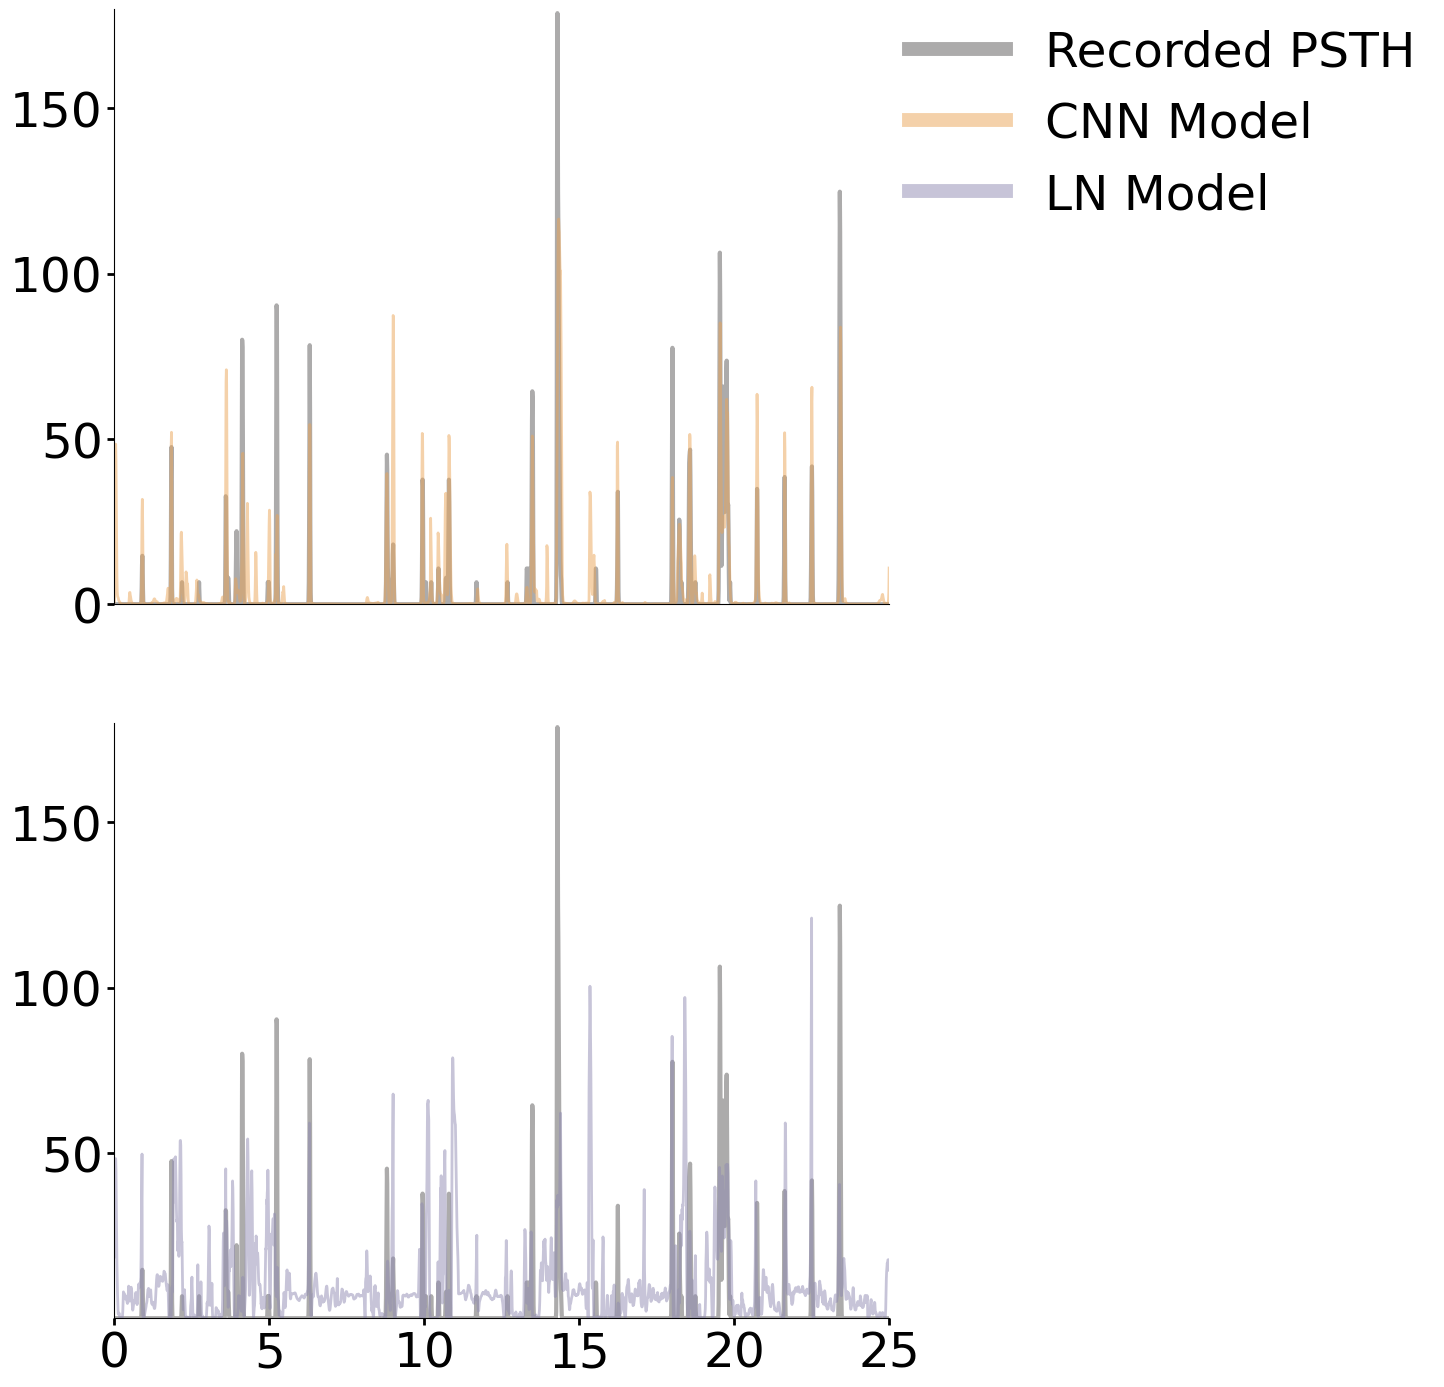

End Cell: 10




Begin Cell: 11


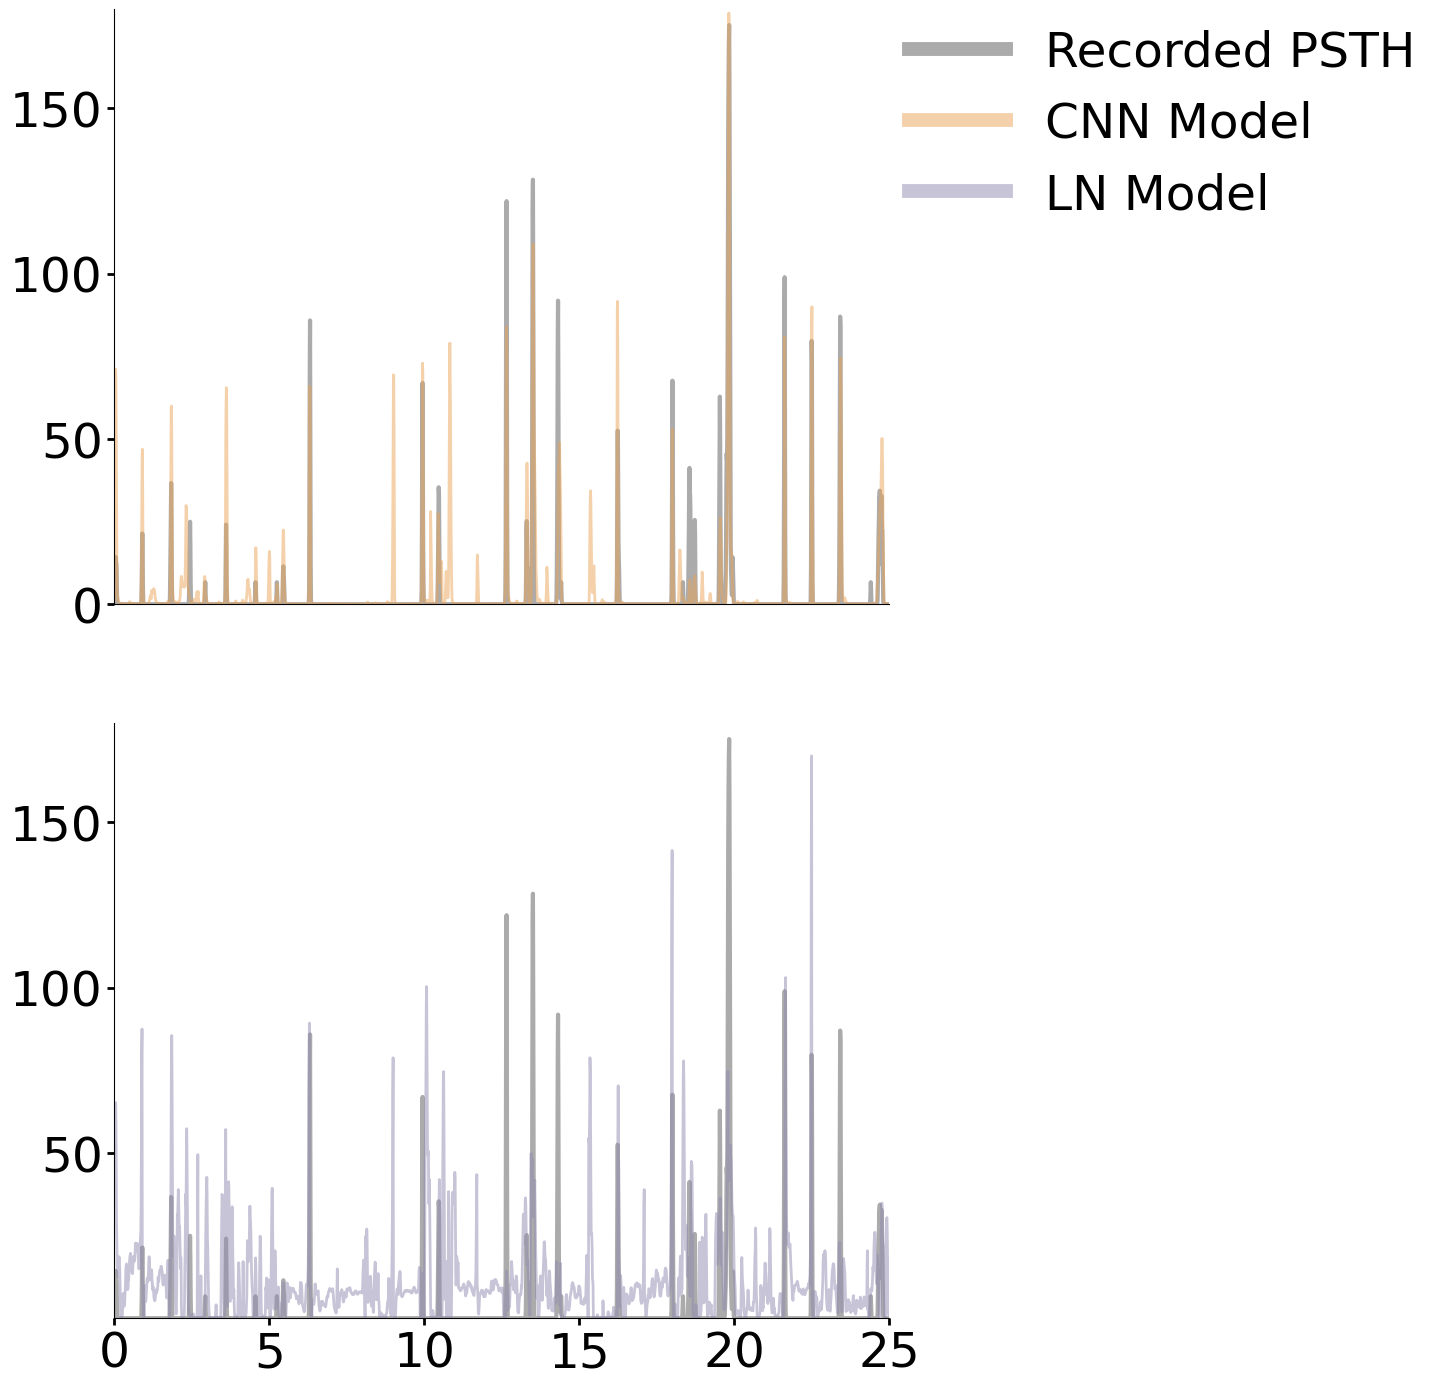

End Cell: 11




Begin Cell: 12


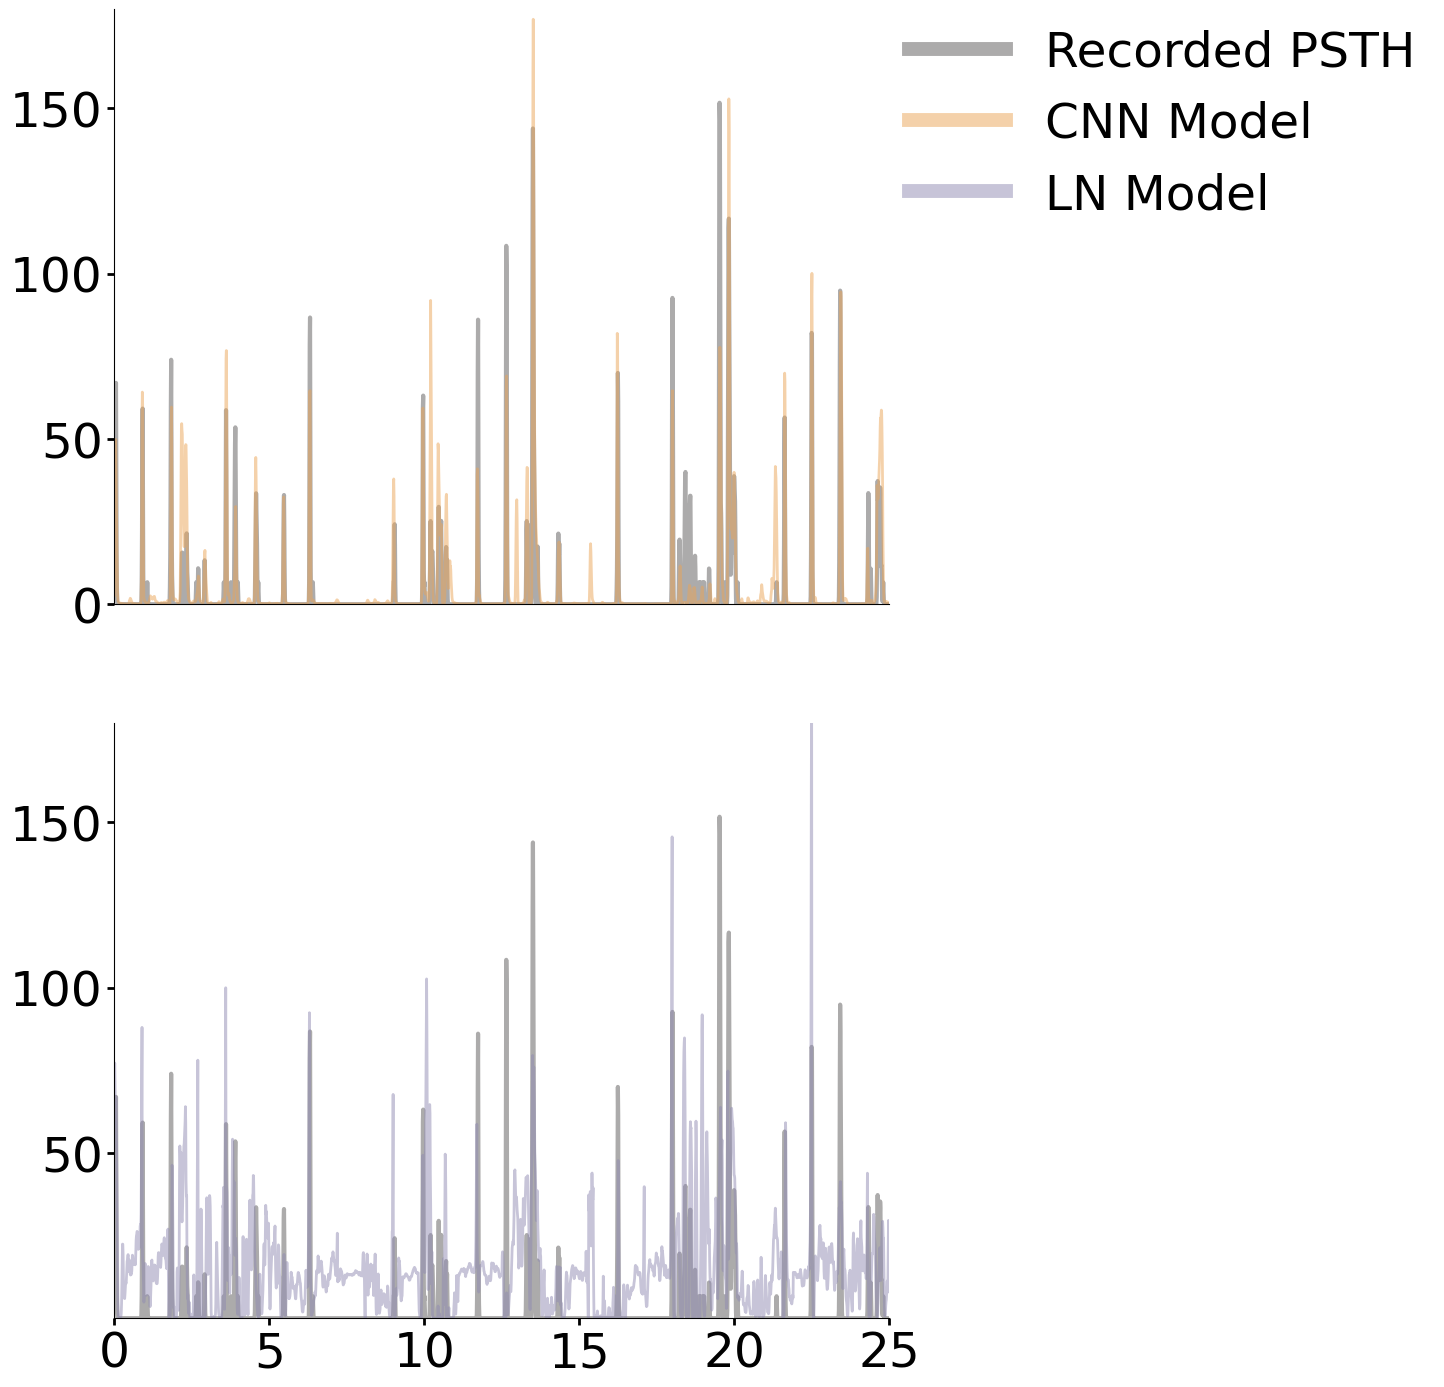

End Cell: 12




Begin Cell: 7


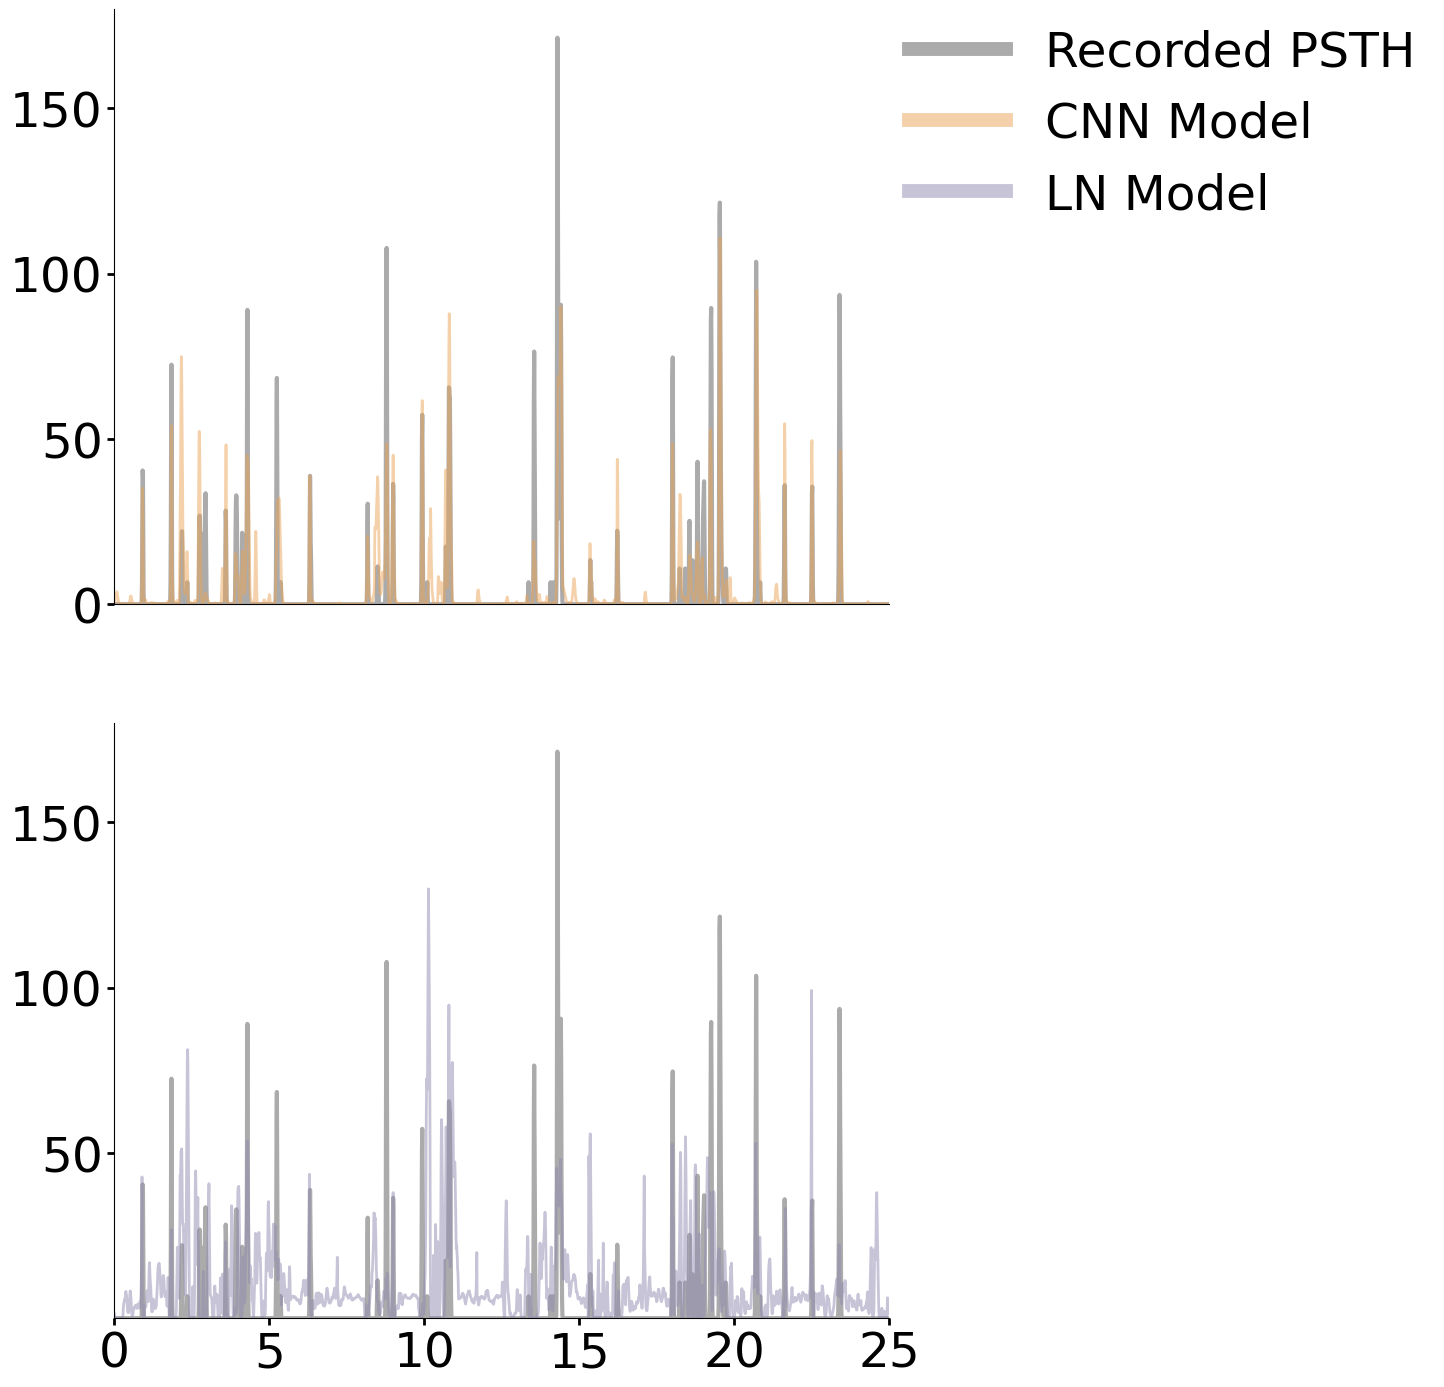

End Cell: 7




Begin Cell: 14


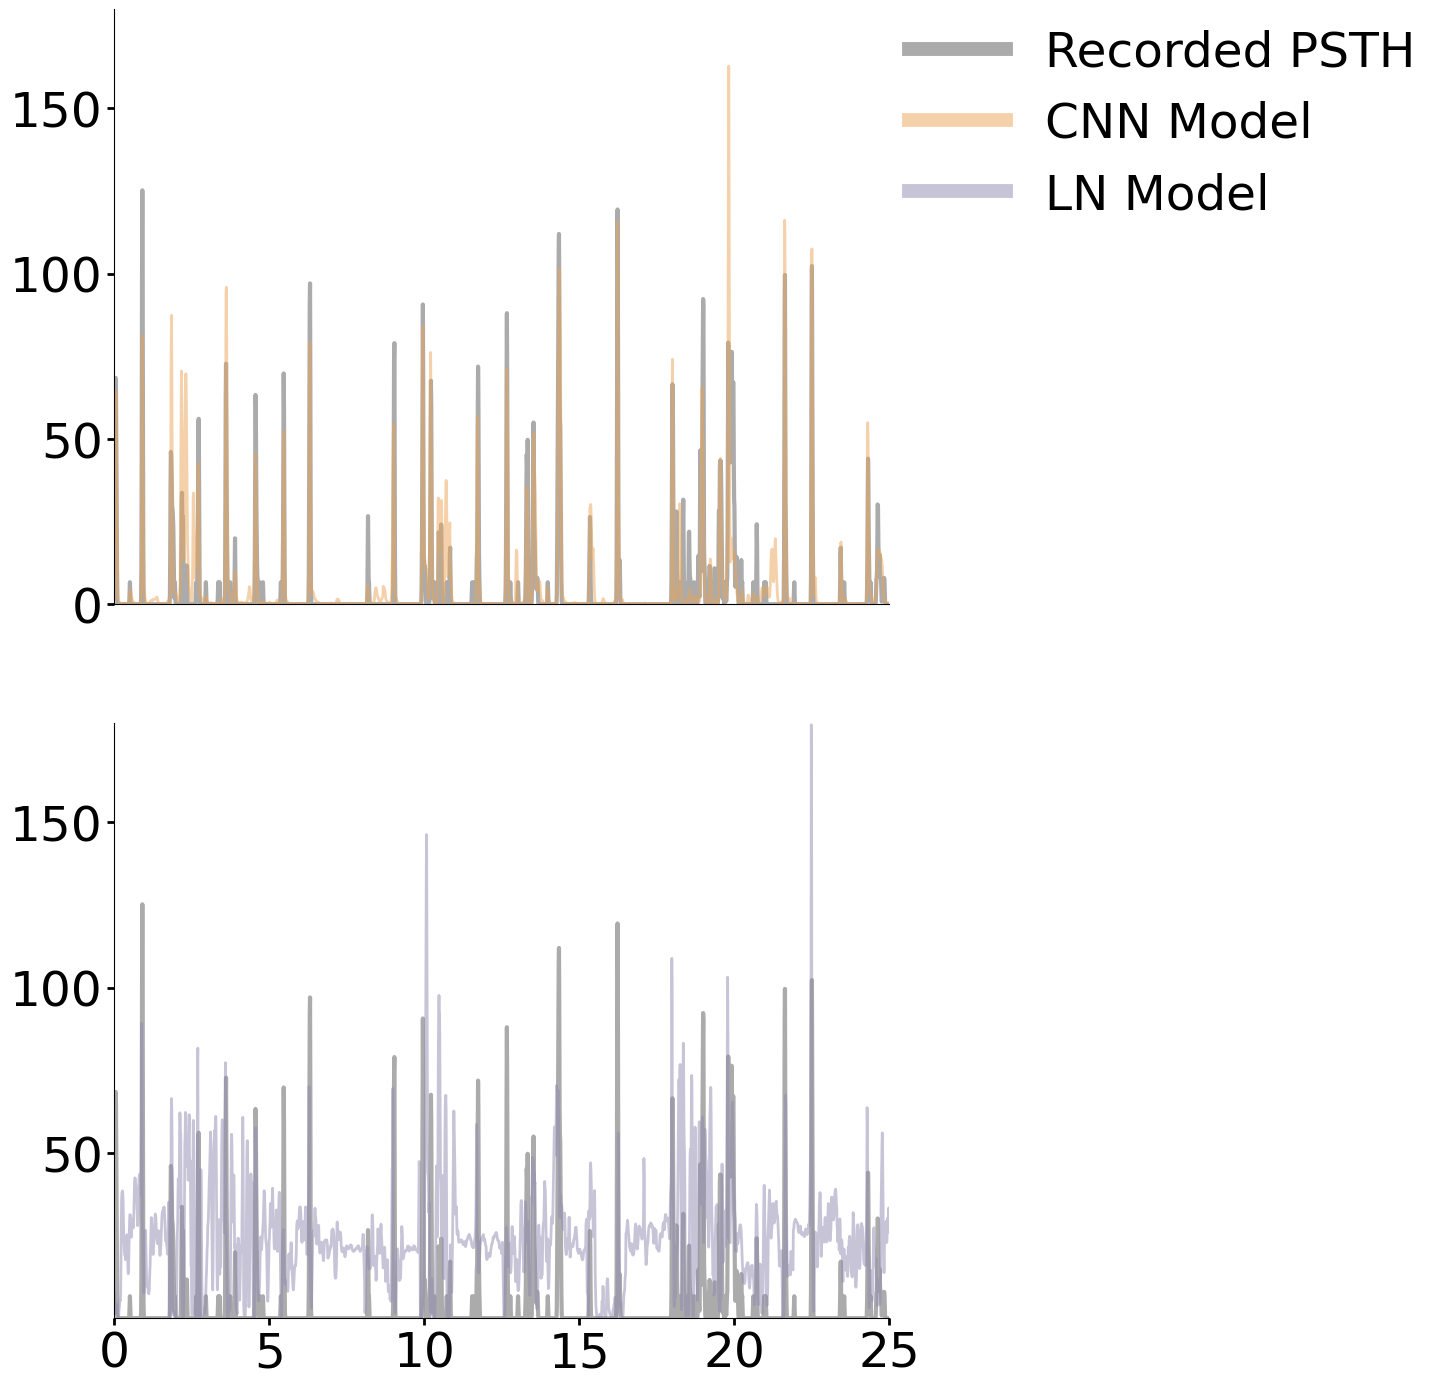

End Cell: 14






In [22]:
prepath = "~/src/torch-deep-retina/models/"
prename = "convgc_"

# Sets base window
startx = 1500
endx = 4000
n_ms = endx-startx

dataset = "15-11-21b"
stim_type = "naturalscene"
colors = {
    "recorded": "#ACABAB",
    #"cnn":      sns.color_palette()[0],
    #"ln":       sns.color_palette()[3],
    "cnn": "#EBA557",
    "ln":  "#908BB2",
    #"cnn":      sns.color_palette("pastel")[0],
    #"ln":       sns.color_palette("pastel")[3],
}
s = "{}_{}.pt".format(dataset,stim_type)
path = os.path.join(prepath,prename+s)
model = tdr.io.load_model(path).cuda()
model.eval()
data = tdr.datas.loadexpt(dataset,'all',stim_type,'test',model.img_shape[0])
traces = {
    "cnn": dict(),
    "ln": dict(),
    "real": dict(),
}
keepers = [10,11,12,7,14]
# Do the normalization over all the data
with torch.no_grad():
    X = torch.FloatTensor(data.X[startx:endx]).cuda()
    preds = model(X).data.cpu()
    model.cpu()
    for ci in keepers:
        print("Begin Cell:", ci)
        ln = tdr.io.load_model(cell2ln[ci]).cuda()
        ln_pred = ln(X).data.cpu()
        pred = preds[:,ci]
        real_mean, real_std = data.y[:,ci].mean(), data.y[:,ci].std()
        real = data.y[startx:endx,ci]
        zpred = (pred-pred.mean())/pred.std()
        pred = zpred*real_std + real_mean
        pred = pred-pred.min()
        
        zln_pred = (ln_pred-pred.mean())/ln_pred.std()
        ln_pred = zln_pred*real_std + real_mean
        ln_pred = ln_pred-ln_pred.min()
        
        traces["cnn"][ci] = pred
        traces["ln"][ci] = ln_pred
        traces["real"][ci] = real
        
        recorded_alpha = 1
        alpha = .5
        linewidth = 2
        greyline = linewidth + 1
        ticksize = 35
        width = 2 # ticks
        length = 5 # ticks
        #fig, axs = plt.subplots(2,1,figsize=(12,17))
        fig, axs = plt.subplots(2,1,figsize=(10,17))
        
        plt.sca(axs[0])
        plt.plot(real,label="Recorded PSTH",color=colors["recorded"],alpha=recorded_alpha,linewidth=greyline)
        plt.plot(pred,label="CNN Model",    color=colors["cnn"],alpha=alpha,linewidth=linewidth)
        plt.plot([200], label="LN Model",  color=colors["ln"], alpha=alpha, linewidth=linewidth)
        leg = plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.,fontsize=35,frameon=False)
        for line in leg.get_lines():
            line.set_linewidth(10.0)
        plt.xticks([])
        plt.xlim([0,n_ms])
        plt.ylim([0,180])
        plt.yticks([0,50,100,150])
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=ticksize, width=width, length=length)
        
        plt.sca(axs[1])
        plt.plot(real,label="Recorded PSTH",color=colors["recorded"],alpha=recorded_alpha,linewidth=greyline)
        plt.plot(ln_pred,label="LN Model",  color=colors["ln"],alpha=alpha,linewidth=linewidth)

        plt.xlim([0,n_ms])
        time_inc = n_ms//2 if n_ms<500 else 500
        xticks = range(0,len(real)+1,time_inc)
        plt.xticks(xticks,[str(int(x/100)) for x in xticks])
        plt.ylim([0,180])
        plt.yticks([50,100,150])
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=ticksize, width=width, length=length)
        #
#       #  plt.title("{} {} {}".format(dataset,stim_type, ci))
        t = n_ms/100
        plt.savefig("psth_nat15-11-21b_{}s_{}.pdf".format(t,ci), bbox_inches="tight")
        plt.savefig("psth_nat15-11-21b_{}s_{}.png".format(t,ci), bbox_inches="tight")
        plt.show()
#
        print("End Cell:", ci)
        print("\n\n\n")
            



Begin Cell: 10


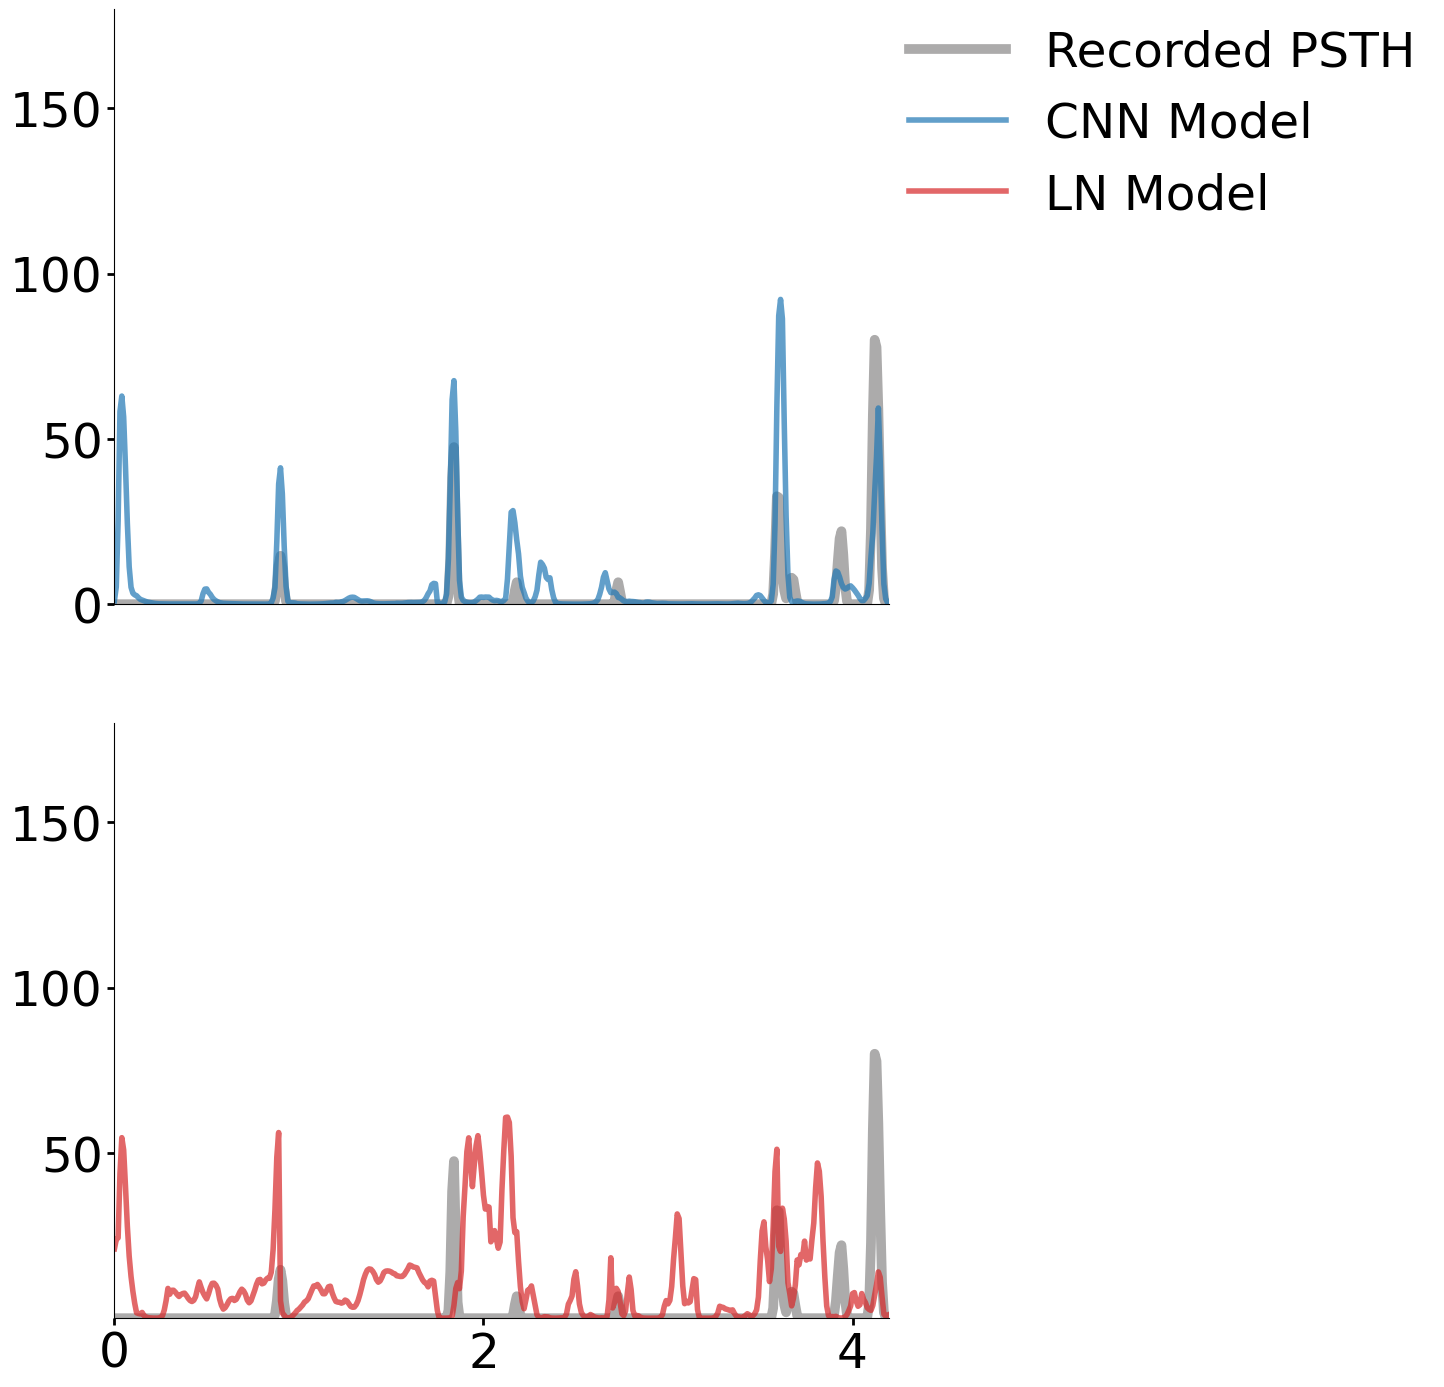

End Cell: 10




Begin Cell: 12


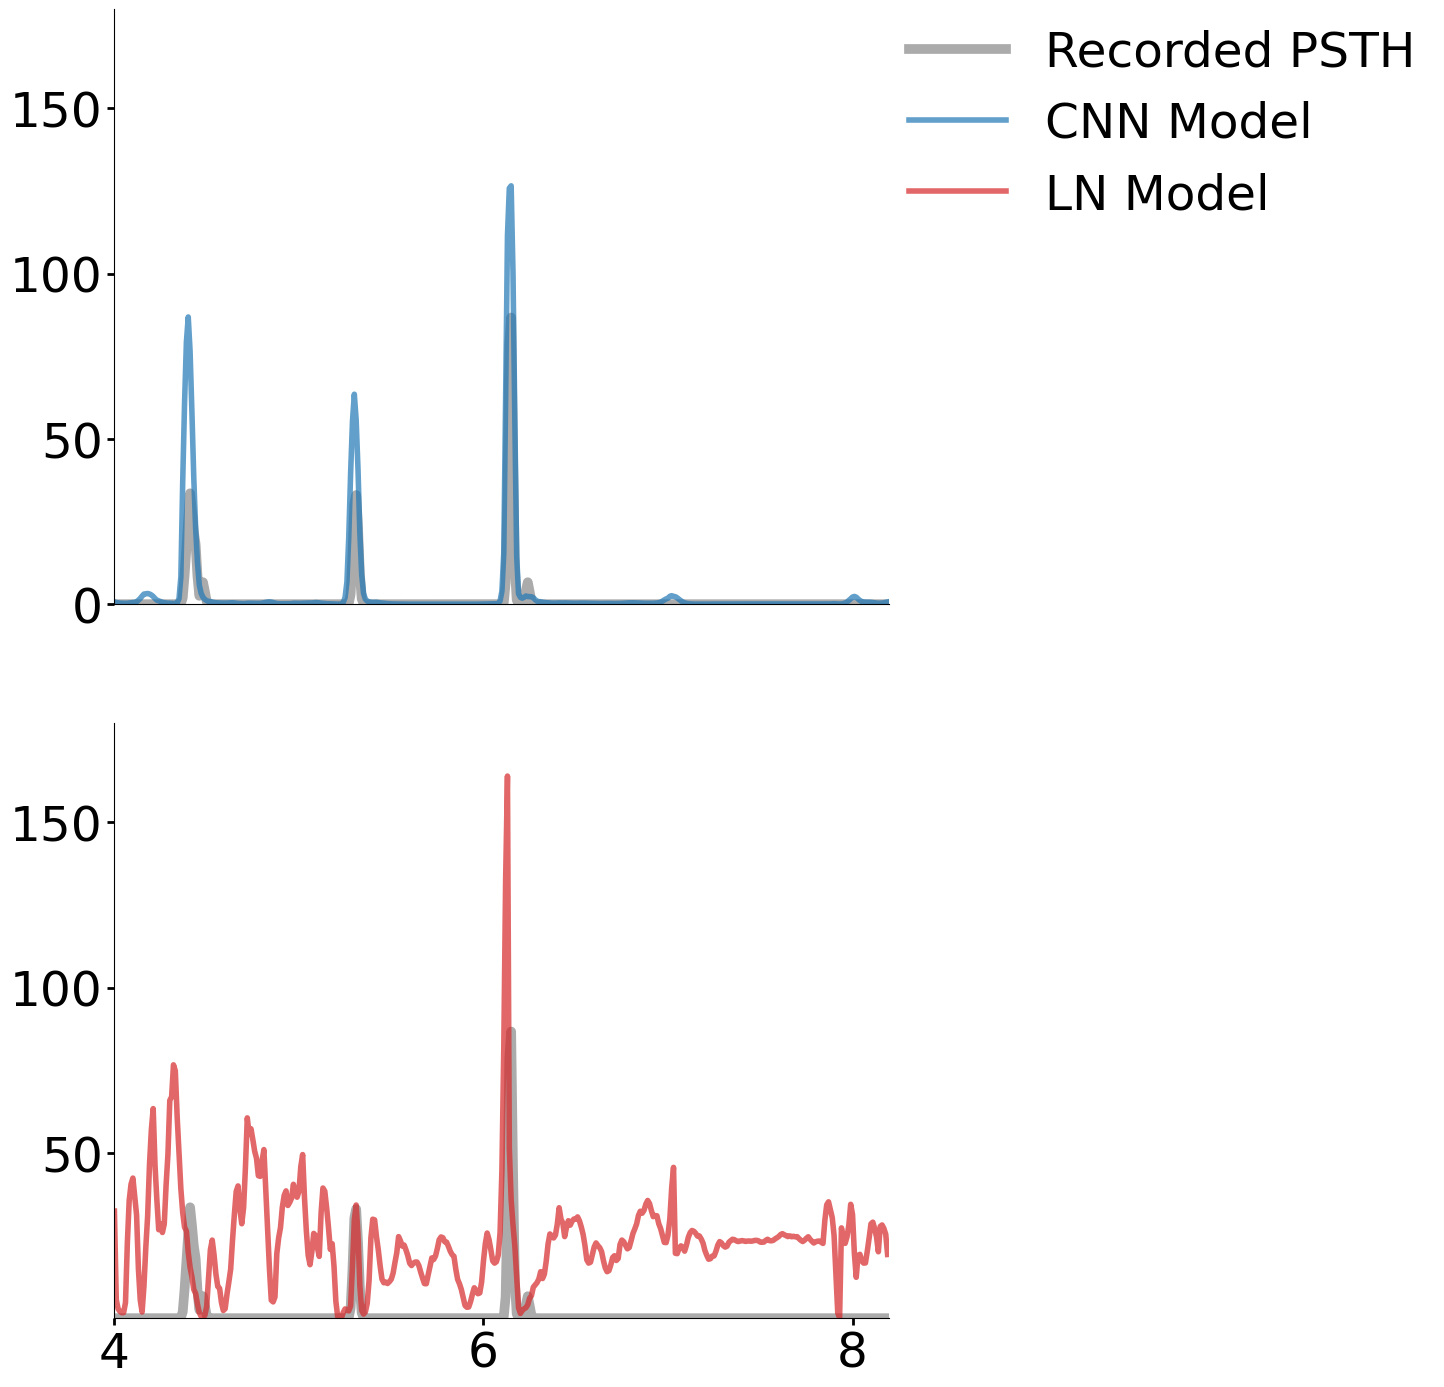

End Cell: 12




Begin Cell: 7


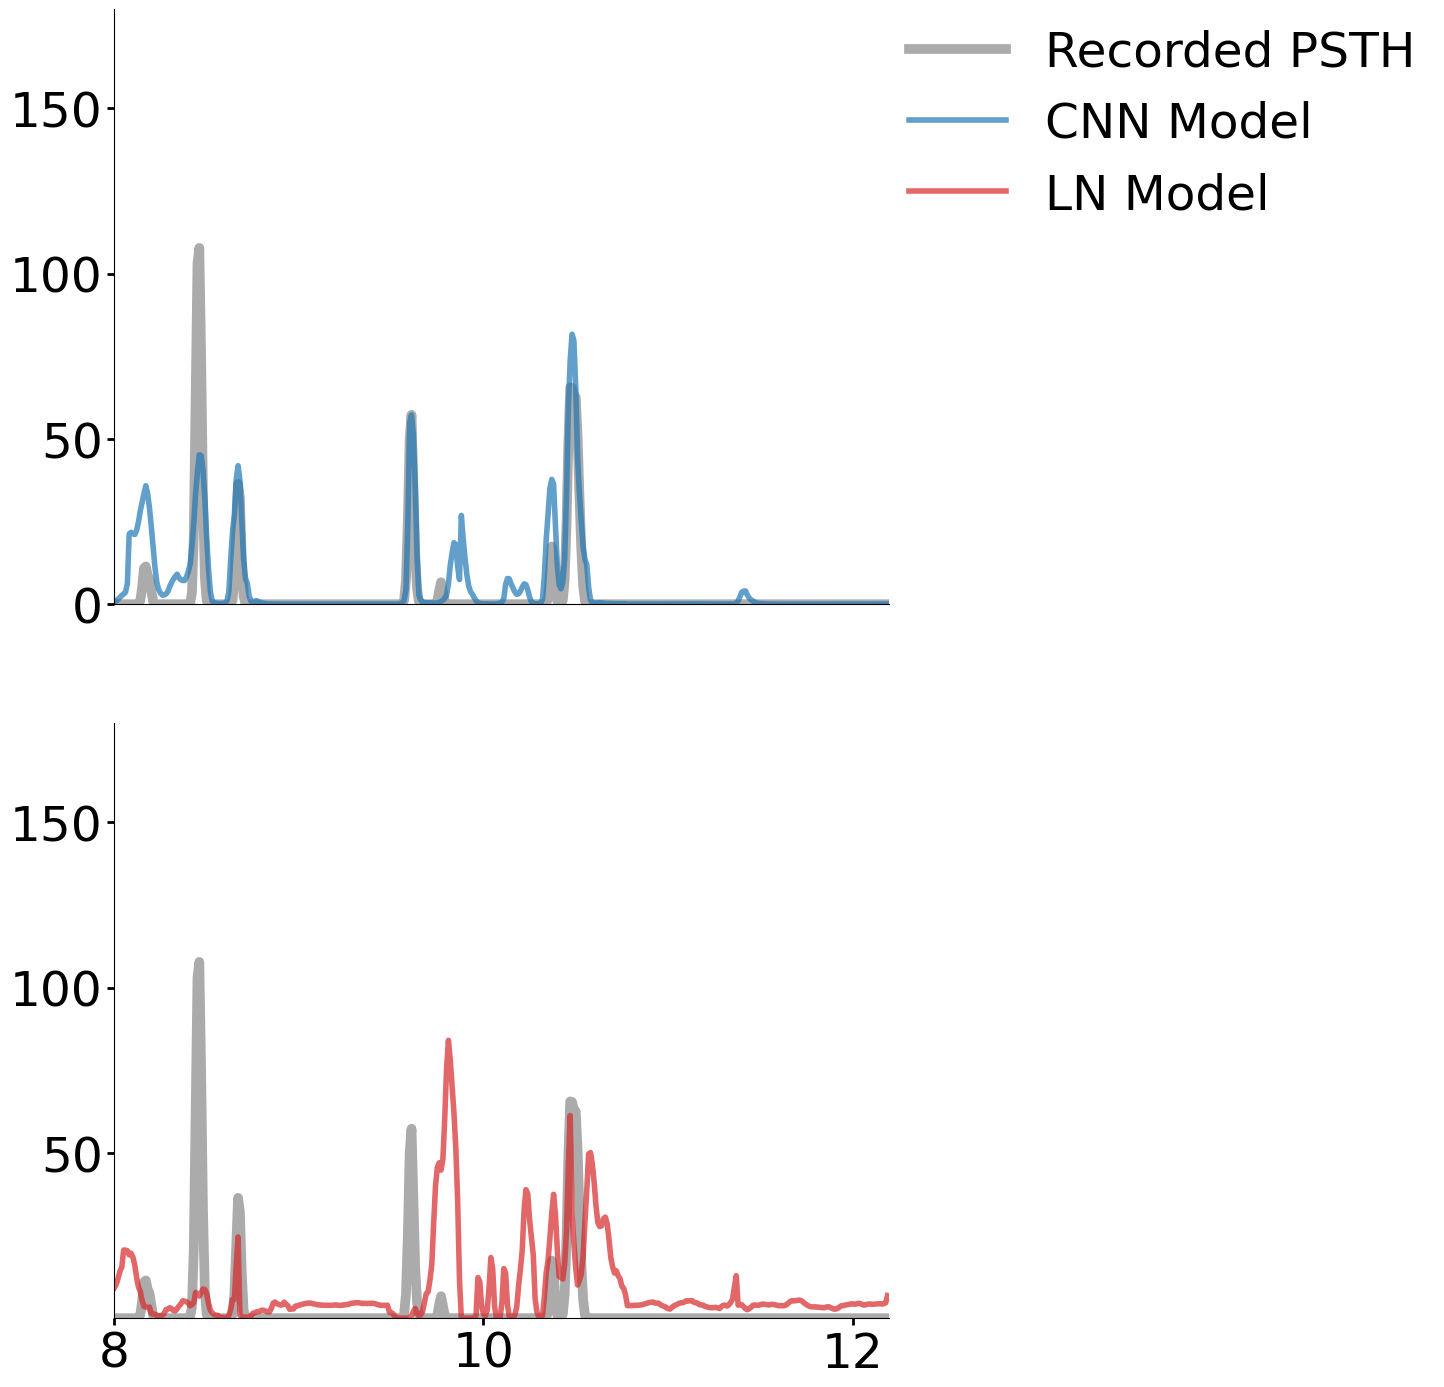

End Cell: 7




Begin Cell: 11


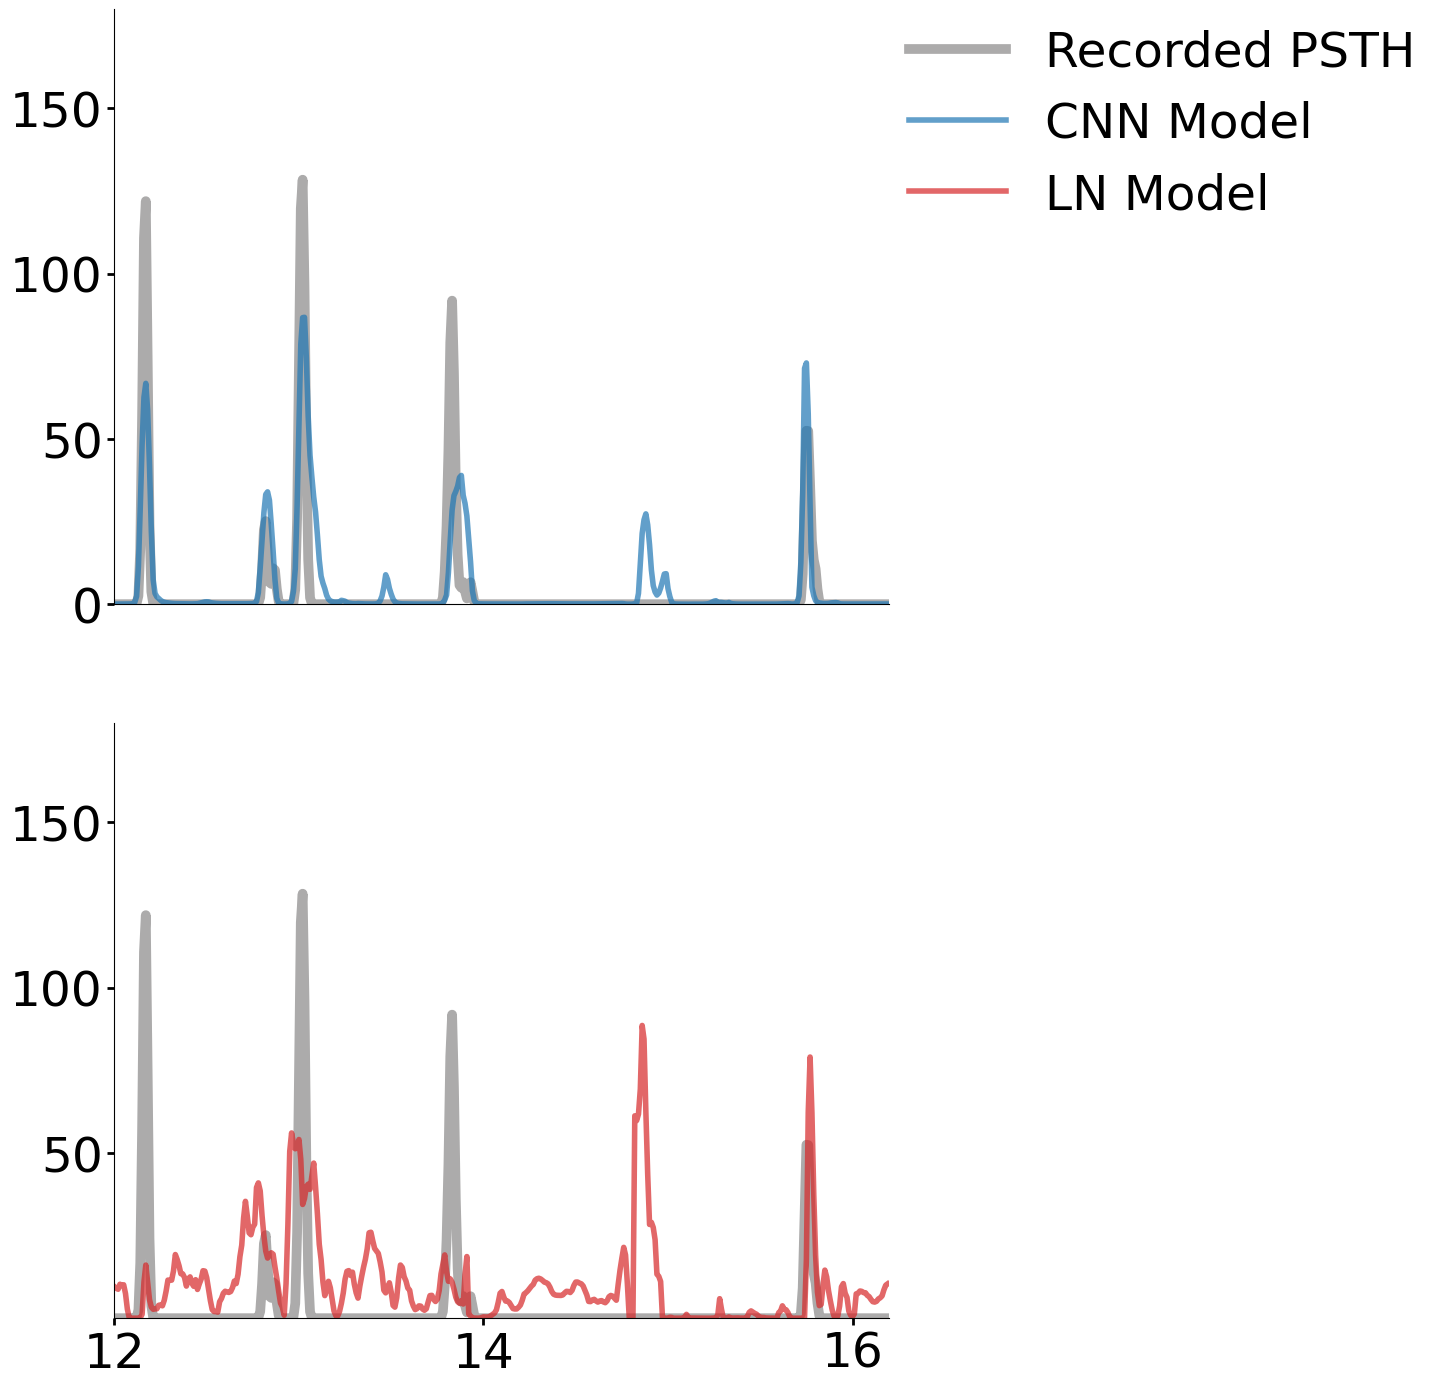

End Cell: 11




Begin Cell: 14


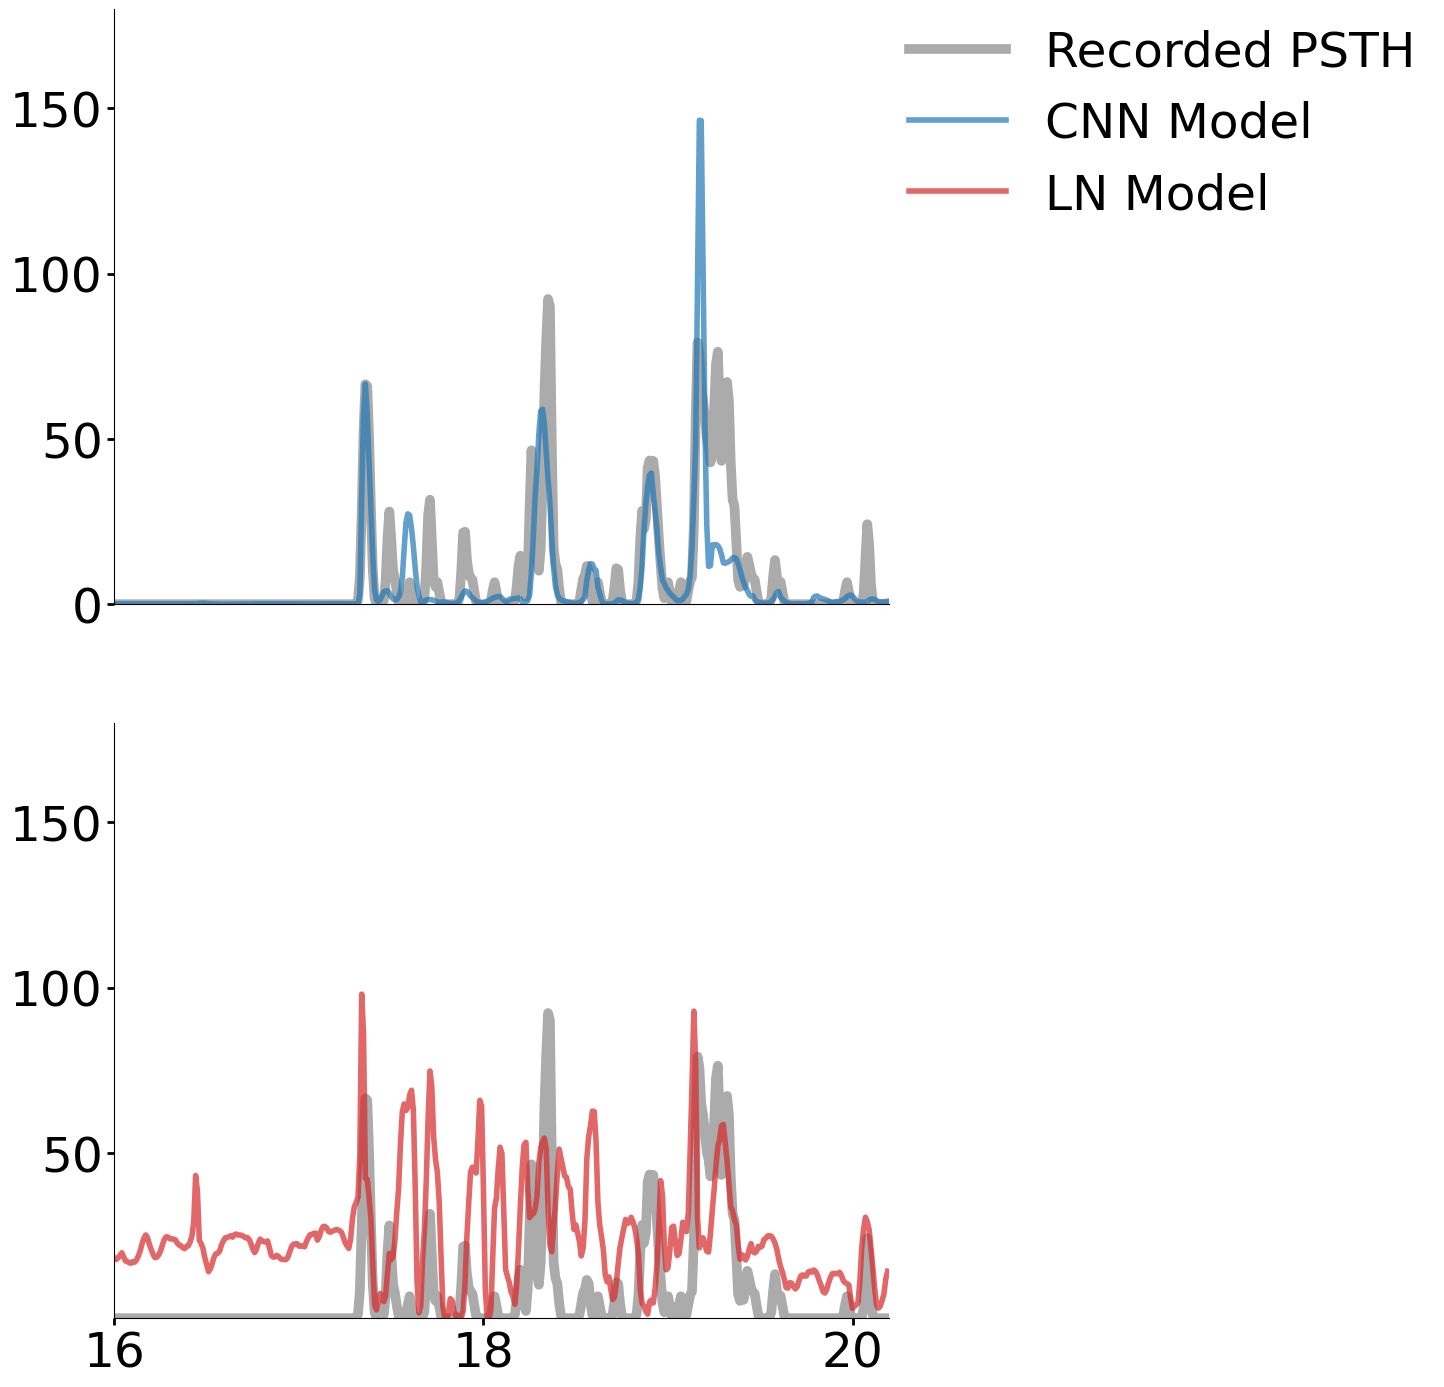

End Cell: 14






In [21]:
# Sets base window
big_startx = 1500
big_endx = 4000
#n_ms = 2500

# Sets zoomed window
startx = 1250
endx = 1670

n_ms = endx-startx
model.cuda()
model.eval()
keepers = [10,12,7,11,14]
zoomed_traces = {
    "cnn": dict(),
    "ln": dict(),
    "real": dict(),
}
with torch.no_grad():
    X = torch.FloatTensor(data.X[big_startx:big_endx]).cuda()
    real = data.y[big_startx:big_endx]
    preds = model(X).data.cpu()
    model.cpu()
    for loop,ci in enumerate(keepers):
        print("Begin Cell:", ci)
        ln = tdr.io.load_model(cell2ln[ci]).cuda()
        ln_pred = ln(X).data.cpu()
        
        rand = loop*(big_endx-big_startx-n_ms)//len(keepers)
        ts = rand
        te = rand+n_ms
        
        pred = preds[ts:te,ci]
        real_zoom = real[ts:te,ci]
        real_mean,real_std = data.y[:,ci].mean(), data.y[:,ci].std()
        zpred = (pred-pred.mean())/pred.std()
        pred = zpred*real_std + real_mean
        pred = pred-pred.min()
        
        ln_pred = ln_pred[ts:te]
        zln_pred = (ln_pred-ln_pred.mean())/ln_pred.std()
        ln_pred = zln_pred*real_std + real_mean
        ln_pred = ln_pred-ln_pred.min()
        
        zoomed_traces["cnn"][ci] = pred
        zoomed_traces["ln"][ci] = ln_pred
        zoomed_traces["real"][ci] = real_zoom
        
        alpha = .7
        linewidth = 4
        greyline = linewidth + 3
        ticksize = 35
        width = 2
        length = 5
        #fig, axs = plt.subplots(2,1,figsize=(12,17))
        fig, axs = plt.subplots(2,1,figsize=(10,17))
        
        plt.sca(axs[0])
        plt.plot(real_zoom,label="Recorded PSTH",color=colors["recorded"],alpha=1,linewidth=greyline)
        plt.plot(pred,label="CNN Model",    color=colors["cnn"],alpha=alpha,linewidth=linewidth)
        plt.plot([200], label="LN Model",  color=colors["ln"], alpha=alpha, linewidth=linewidth)
        plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.,fontsize=35,frameon=False)
        for line in leg.get_lines():
            line.set_linewidth(10.0)
        plt.xticks([])
        plt.xlim([0,n_ms])
        plt.ylim([0,180])
        plt.yticks([0,50,100,150])
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=ticksize, width=width, length=length)
        
        plt.sca(axs[1])
        plt.plot(real_zoom,label="Recorded PSTH",color=colors["recorded"],alpha=1,linewidth=greyline)
        plt.plot(ln_pred,label="LN Model",  color=colors["ln"],alpha=alpha,linewidth=linewidth)

        plt.xlim([0,n_ms])
        time_inc = n_ms//2 if n_ms<500 else 500
        xticks = np.arange(0,len(real_zoom)+1,time_inc)
        xticks = np.asarray([int(x/100)*100 for x in xticks])
        xt_labels = xticks+ts
        plt.xticks(xticks, [str(int(x/100)) for x in xt_labels])
        plt.ylim([0,180])
        plt.yticks([50,100,150])
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=ticksize, width=width, length=length)
        #
#       #  plt.title("{} {} {}".format(dataset,stim_type, ci))
        t = n_ms/100
        plt.savefig("zoomed_psth_nat15-11-21b_{}s_{}.pdf".format(t,ci), bbox_inches="tight")
        plt.savefig("zoomed_psth_nat15-11-21b_{}s_{}.png".format(t,ci), bbox_inches="tight")
        plt.show()
#
        print("End Cell:", ci)
        print("\n\n\n")
            



## Final Fig

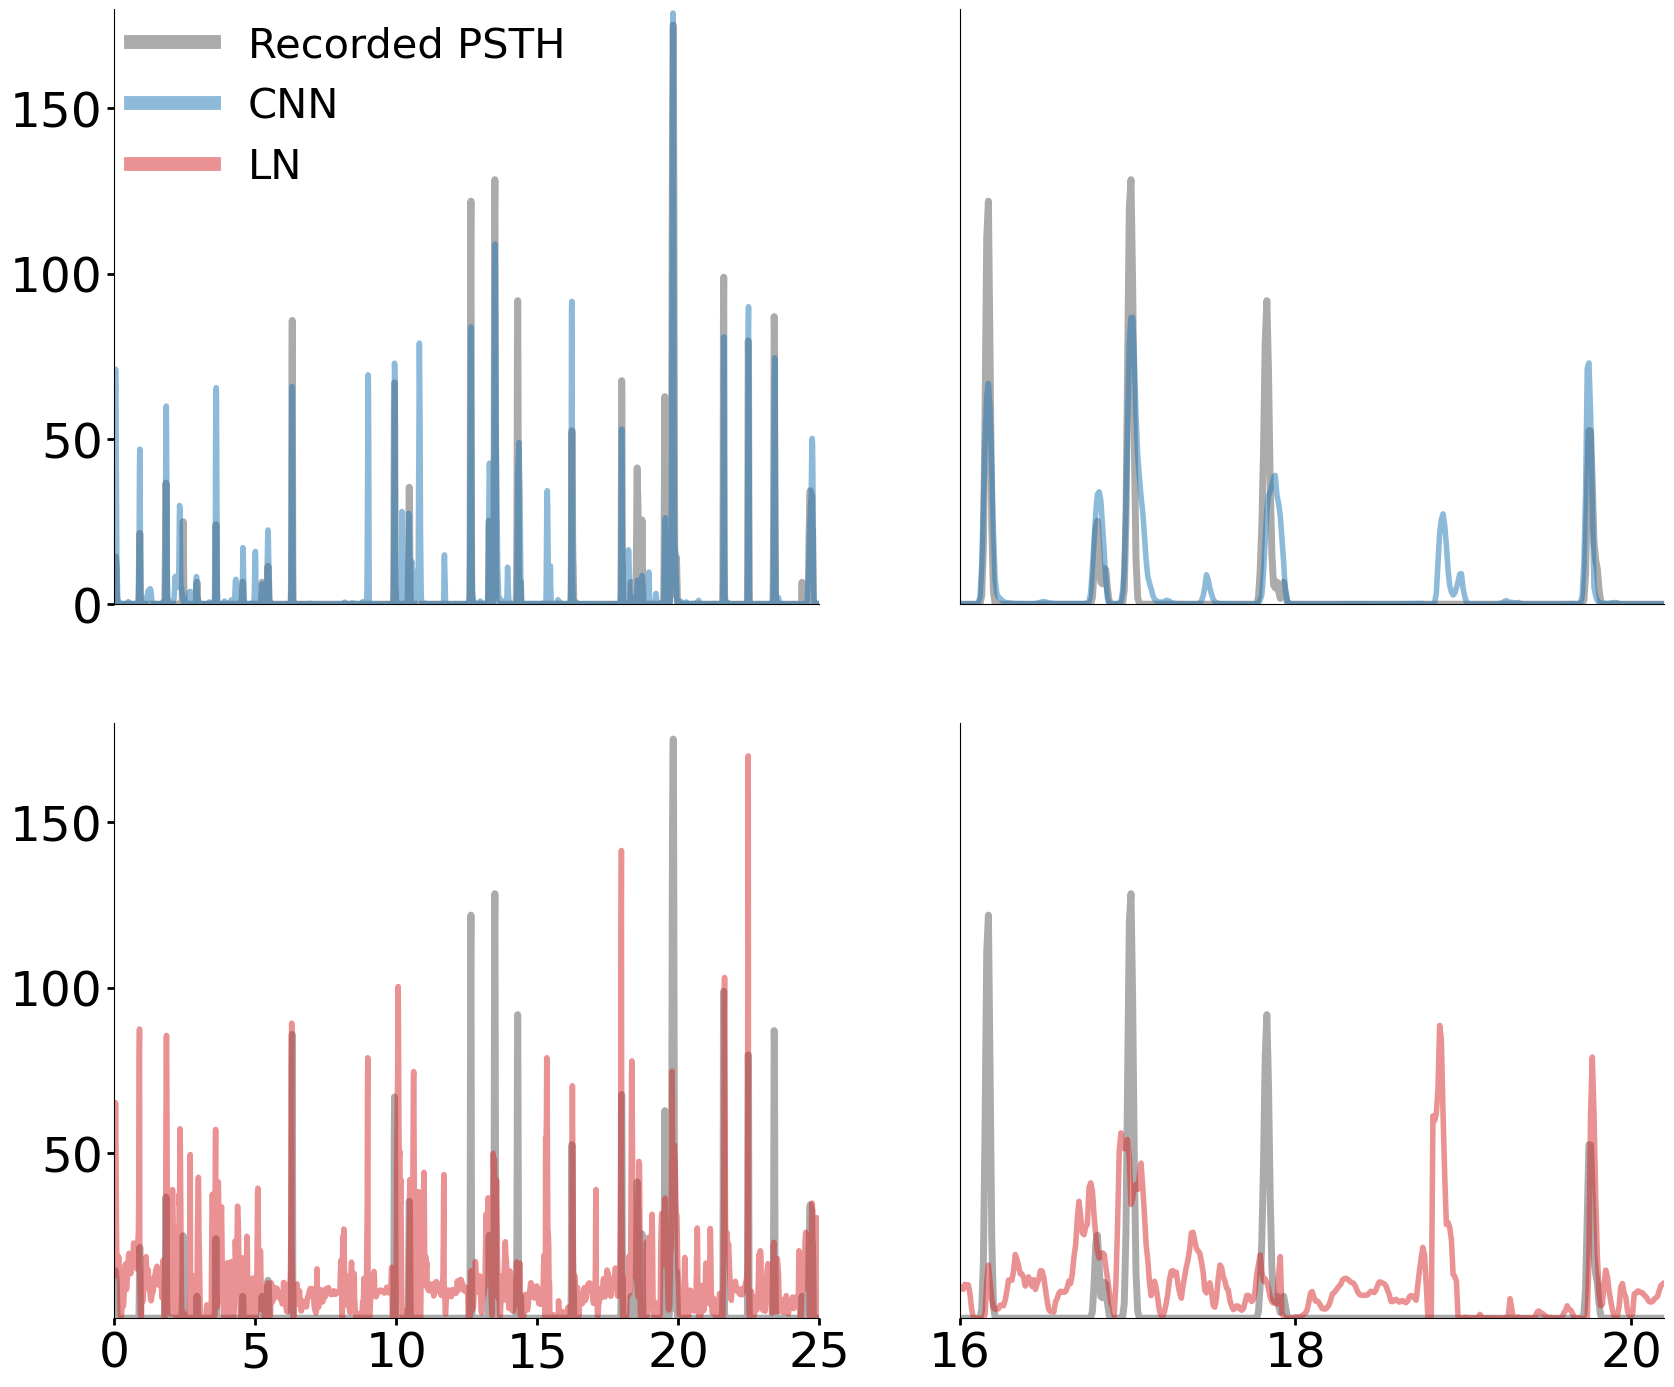

End Cell: 14






In [20]:
cell = 11

# Sets base window
startx = 1500
endx = 4000
n_ms = endx-startx

pred = traces["cnn"][cell]
ln_pred = traces["ln"][cell]
real = traces["real"][cell]

legendsize = 30
recorded_alpha = 1
alpha = .5
linewidth = 4
greyline = linewidth + 1
ticksize = 35
width = 2 # ticks
length = 5 # ticks



fig, axs = plt.subplots(2,2,figsize=(20,17))

plt.sca(axs[0][0])
plt.plot(real,label="Recorded PSTH",color=colors["recorded"],alpha=recorded_alpha,linewidth=greyline)
plt.plot(pred,label="CNN",    color=colors["cnn"],alpha=alpha,linewidth=linewidth)
plt.plot([200], label="LN",  color=colors["ln"], alpha=alpha, linewidth=linewidth)
#leg = plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.,fontsize=35,frameon=False)
leg = plt.legend(loc="upper left", borderaxespad=0.,fontsize=legendsize,frameon=False)
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.xticks([])
plt.xlim([0,n_ms])
plt.ylim([0,180])
plt.yticks([0,50,100,150])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=ticksize, width=width, length=length)

plt.sca(axs[1][0])
plt.plot(real,label="Recorded PSTH",color=colors["recorded"],alpha=recorded_alpha,linewidth=greyline)
plt.plot(ln_pred,label="LN",  color=colors["ln"],alpha=alpha,linewidth=linewidth)

plt.xlim([0,n_ms])
time_inc = n_ms//2 if n_ms<500 else 500
xticks = range(0,len(real)+1,time_inc)
plt.xticks(xticks,[str(int(x/100)) for x in xticks])
plt.ylim([0,180])
plt.yticks([50,100,150])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=ticksize, width=width, length=length)
#
#  plt.title("{} {} {}".format(dataset,stim_type, ci))
t = n_ms/100
#plt.savefig("psth_nat15-11-21b_{}s_{}.pdf".format(t,ci), bbox_inches="tight")
#plt.savefig("psth_nat15-11-21b_{}s_{}.png".format(t,ci), bbox_inches="tight")
#plt.show()


startx = 1250
endx = 1670

n_ms = endx-startx
        
real_zoom = zoomed_traces["real"][cell]
pred = zoomed_traces["cnn"][cell]
ln_pred = zoomed_traces["ln"][cell]

plt.sca(axs[0][1])
plt.plot(real_zoom,label="Recorded PSTH",color=colors["recorded"],alpha=1,linewidth=greyline)
plt.plot(pred,label="CNN",    color=colors["cnn"],alpha=alpha,linewidth=linewidth)
plt.plot([200], label="LN",  color=colors["ln"], alpha=alpha, linewidth=linewidth)
#plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.,fontsize=35,frameon=False)
#for line in leg.get_lines():
#    line.set_linewidth(10.0)
plt.xticks([])
plt.xlim([0,n_ms])
plt.ylim([0,180])
plt.yticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=ticksize, width=width, length=length)

plt.sca(axs[1][1])
plt.plot(real_zoom,label="Recorded PSTH",color=colors["recorded"],alpha=1,linewidth=greyline)
plt.plot(ln_pred,label="LN",  color=colors["ln"],alpha=alpha,linewidth=linewidth)

plt.xlim([0,n_ms])
time_inc = n_ms//2 if n_ms<500 else 500
xticks = np.arange(0,len(real_zoom)+1,time_inc)
xticks = np.asarray([int(x/100)*100 for x in xticks])
xt_labels = xticks+ts
plt.xticks(xticks, [str(int(x/100)) for x in xt_labels])
plt.ylim([0,180])
plt.yticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=ticksize, width=width, length=length)
#
plt.savefig("combined_psth_nat15-11-21b_{}.pdf".format(cell), bbox_inches="tight")
plt.savefig("combined_psth_nat15-11-21b_{}.png".format(cell), bbox_inches="tight")
plt.show()

print("End Cell:", ci)
print("\n\n\n")
            
